In [2]:
import os
import json
import requests
import time 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from functions import load_api_key, point_plotting, plotting

pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [3]:
rental_data_df = pd.read_csv('inputs/rental_with_coordinates.csv')

In [4]:
income_df = pd.read_csv('inputs/TaxableIndividualsbyAssessedIncomeGroup.csv')
income_df = income_df[income_df['year_of_assessment'].between(2020, 2024)]
income_df['year_of_assessment'] = income_df['year_of_assessment'].astype(int)

In [5]:
income_df

,year_of_assessment,assessed_income_group,resident_type,number_of_taxpayers,assessable_income,chargeable_income,net_tax_assessed
512,2020,"20,000 & below",Tax Resident,0,0,0,0
513,2020,"20,001 - 25,000",Tax Resident,72603,1686107,1609552,3150
514,2020,"25,001 - 30,000",Tax Resident,136157,3781289,3386805,13272
515,2020,"30,001 - 40,000",Tax Resident,355037,12342819,10205862,69448
516,2020,"40,001 - 50,000",Tax Resident,262172,11742424,9256587,110914
...,...,...,...,...,...,...,...
635,2023,"200,001 - 300,000",Non-Tax Resident,259,63086,63086,10474
636,2023,"300,001 - 400,000",Non-Tax Resident,81,27830,27818,4544
637,2023,"400,001 - 500,000",Non-Tax Resident,37,16520,16317,2985
638,2023,"500,001 - 1,000,000",Non-Tax Resident,58,38634,38284,7037


# Number of taxpayers

In [6]:
total_income_ppl_df = pd.DataFrame()
for year in [2020, 2021, 2022, 2023]:
    df = income_df[income_df['year_of_assessment'] == year].groupby('assessed_income_group')['number_of_taxpayers'].sum().reset_index()
    df = df.sort_values('assessed_income_group').T
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index(drop = True)
    df.columns = [col + '_taxpayer' for col in df.columns]
    df['total_taxpayer'] = df.sum(axis = 1)
    df['year'] = year
    total_income_ppl_df = pd.concat([total_income_ppl_df, df])

In [7]:
collapsed_total_income_ppl_df = pd.melt(total_income_ppl_df, id_vars=["year"], var_name="category", value_name="number_of_people")

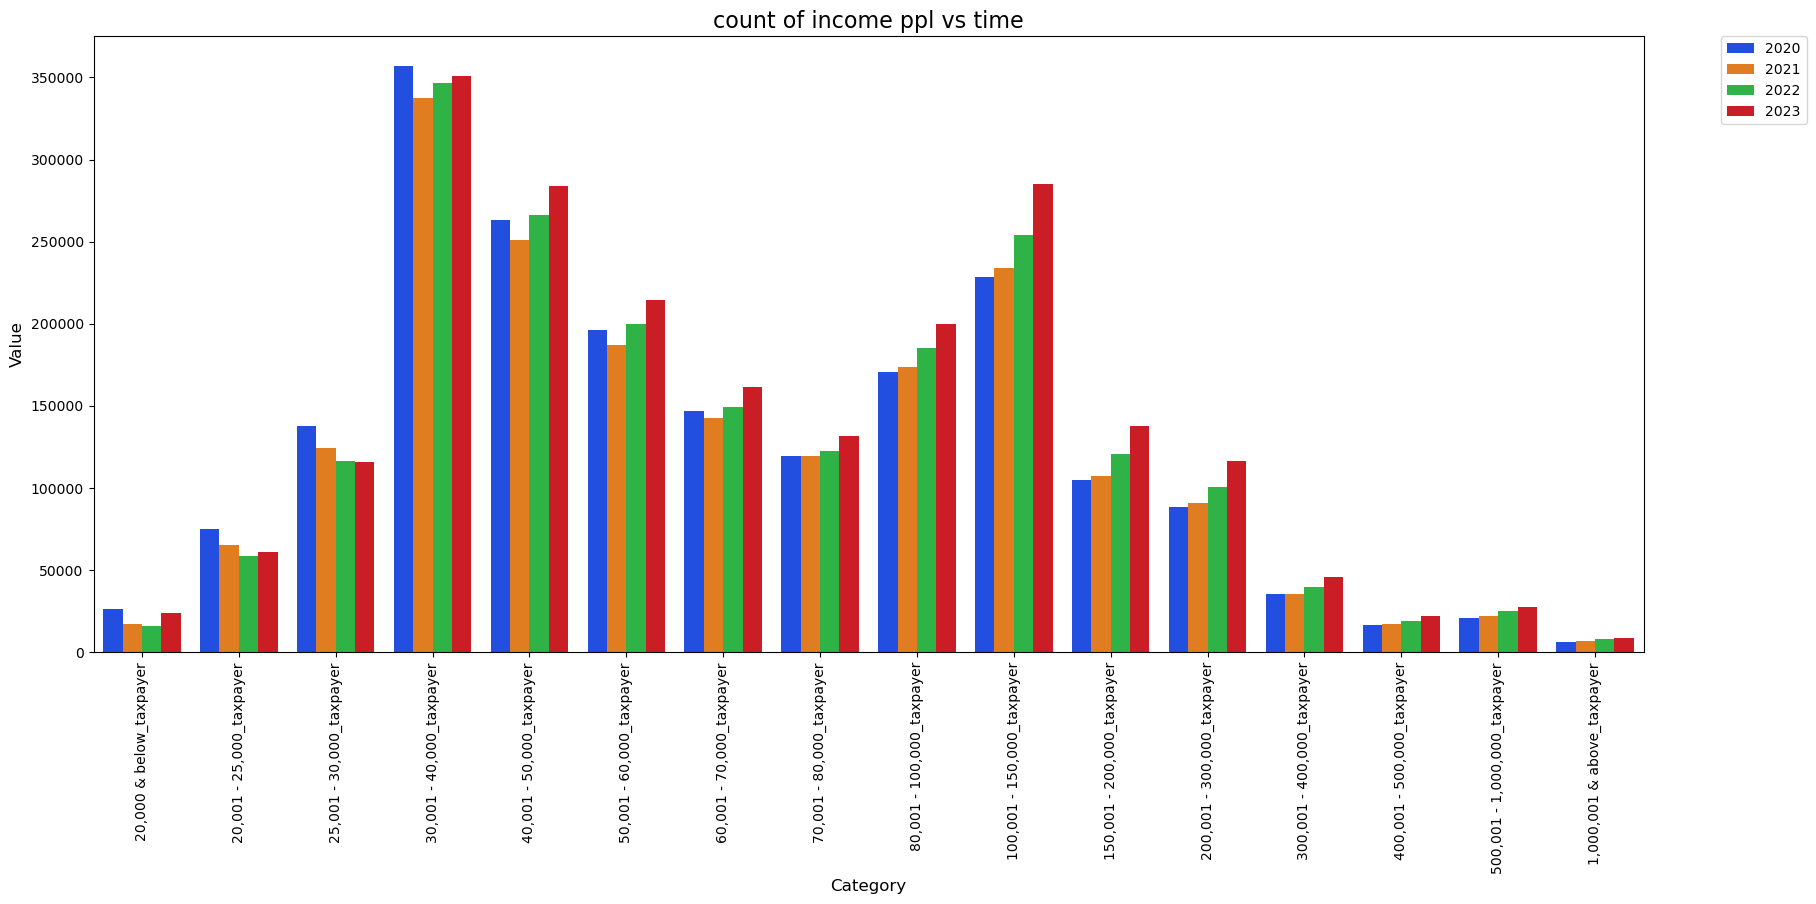

In [8]:
order = [
        '20,000 & below_taxpayer', '20,001 - 25,000_taxpayer', '25,001 - 30,000_taxpayer', '30,001 - 40,000_taxpayer', '40,001 - 50,000_taxpayer', 
        '50,001 - 60,000_taxpayer', '60,001 - 70,000_taxpayer', '70,001 - 80,000_taxpayer', '80,001 - 100,000_taxpayer',
        '100,001 - 150,000_taxpayer', '150,001 - 200,000_taxpayer','200,001 - 300,000_taxpayer', '300,001 - 400,000_taxpayer', '400,001 - 500,000_taxpayer', 
        '500,001 - 1,000,000_taxpayer', '1,000,001 & above_taxpayer']
df = collapsed_total_income_ppl_df[collapsed_total_income_ppl_df['category']!= 'total_taxpayer']
plotting('count of income ppl vs time', 'barplot', df, 'category', 'number_of_people', 'year', desired_order = order)

In [9]:
rate_change_income_ppl_df = df.sort_values(by=['category', 'year']).reset_index(drop=True)
rate_change_income_ppl_df['previous_year_number'] = rate_change_income_ppl_df.groupby('category')['number_of_people'].shift(1)
rate_change_income_ppl_df['ppl_increase_perc'] = (rate_change_income_ppl_df['number_of_people'] - rate_change_income_ppl_df['previous_year_number'])/ rate_change_income_ppl_df['previous_year_number'] * 100
rate_change_income_ppl_df = rate_change_income_ppl_df.dropna()

In [10]:
mean_rental_data_df = rental_data_df.groupby(['year', 'town'])['monthly_rent'].mean().reset_index()
mean_rental_data_df = mean_rental_data_df.sort_values(by=['town', 'year']).reset_index(drop=True)
mean_rental_data_df['previous_year_number'] = mean_rental_data_df.groupby('town')['monthly_rent'].shift(1)
mean_rental_data_df['rent_increase_perc'] = (mean_rental_data_df['monthly_rent'] - mean_rental_data_df['previous_year_number'])/ mean_rental_data_df['previous_year_number'] * 100
mean_rental_data_df = mean_rental_data_df.dropna()

In [11]:
mean_rental_data_df

,year,town,monthly_rent,previous_year_number,rent_increase_perc
1,2022,ANG MO KIO,2346.970619,2000.359287,17.327454
2,2023,ANG MO KIO,2827.720618,2346.970619,20.483852
3,2024,ANG MO KIO,2871.370472,2827.720618,1.543641
5,2022,BEDOK,2369.738392,2035.513006,16.419713
6,2023,BEDOK,2844.830303,2369.738392,20.048285
...,...,...,...,...,...
99,2023,WOODLANDS,2892.715686,2422.199187,19.425178
100,2024,WOODLANDS,2962.523461,2892.715686,2.413226
102,2022,YISHUN,2334.204059,1960.579100,19.056867
103,2023,YISHUN,2824.025784,2334.204059,20.984529


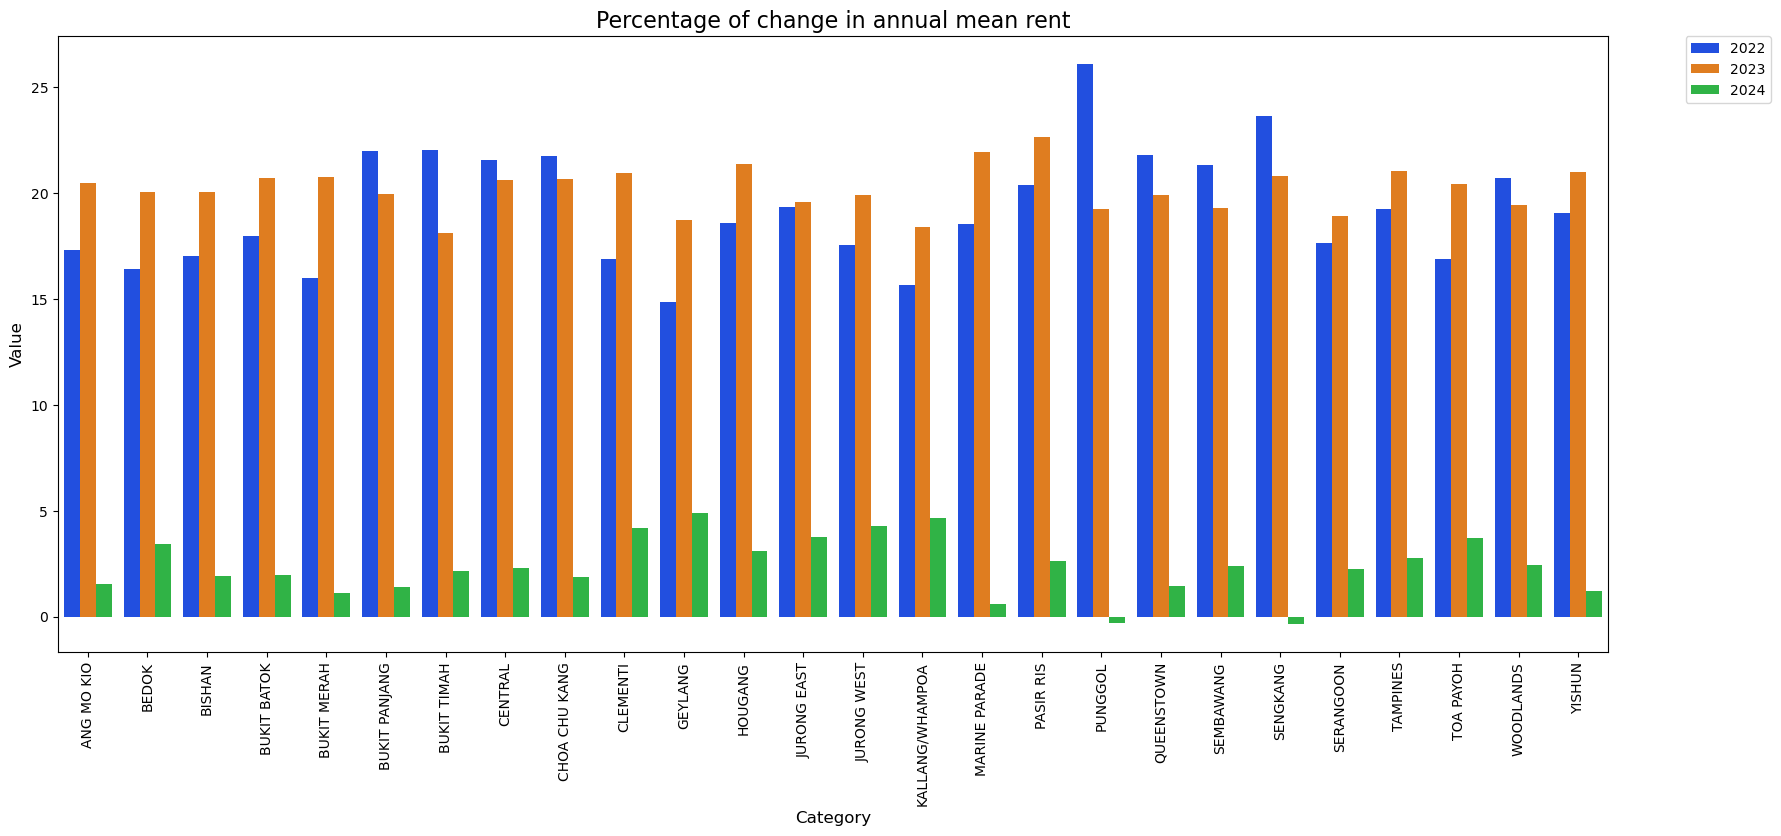

In [20]:
plotting('Percentage of change in annual mean rent', 'barplot', mean_rental_data_df, 'town', 'rent_increase_perc', 'year')

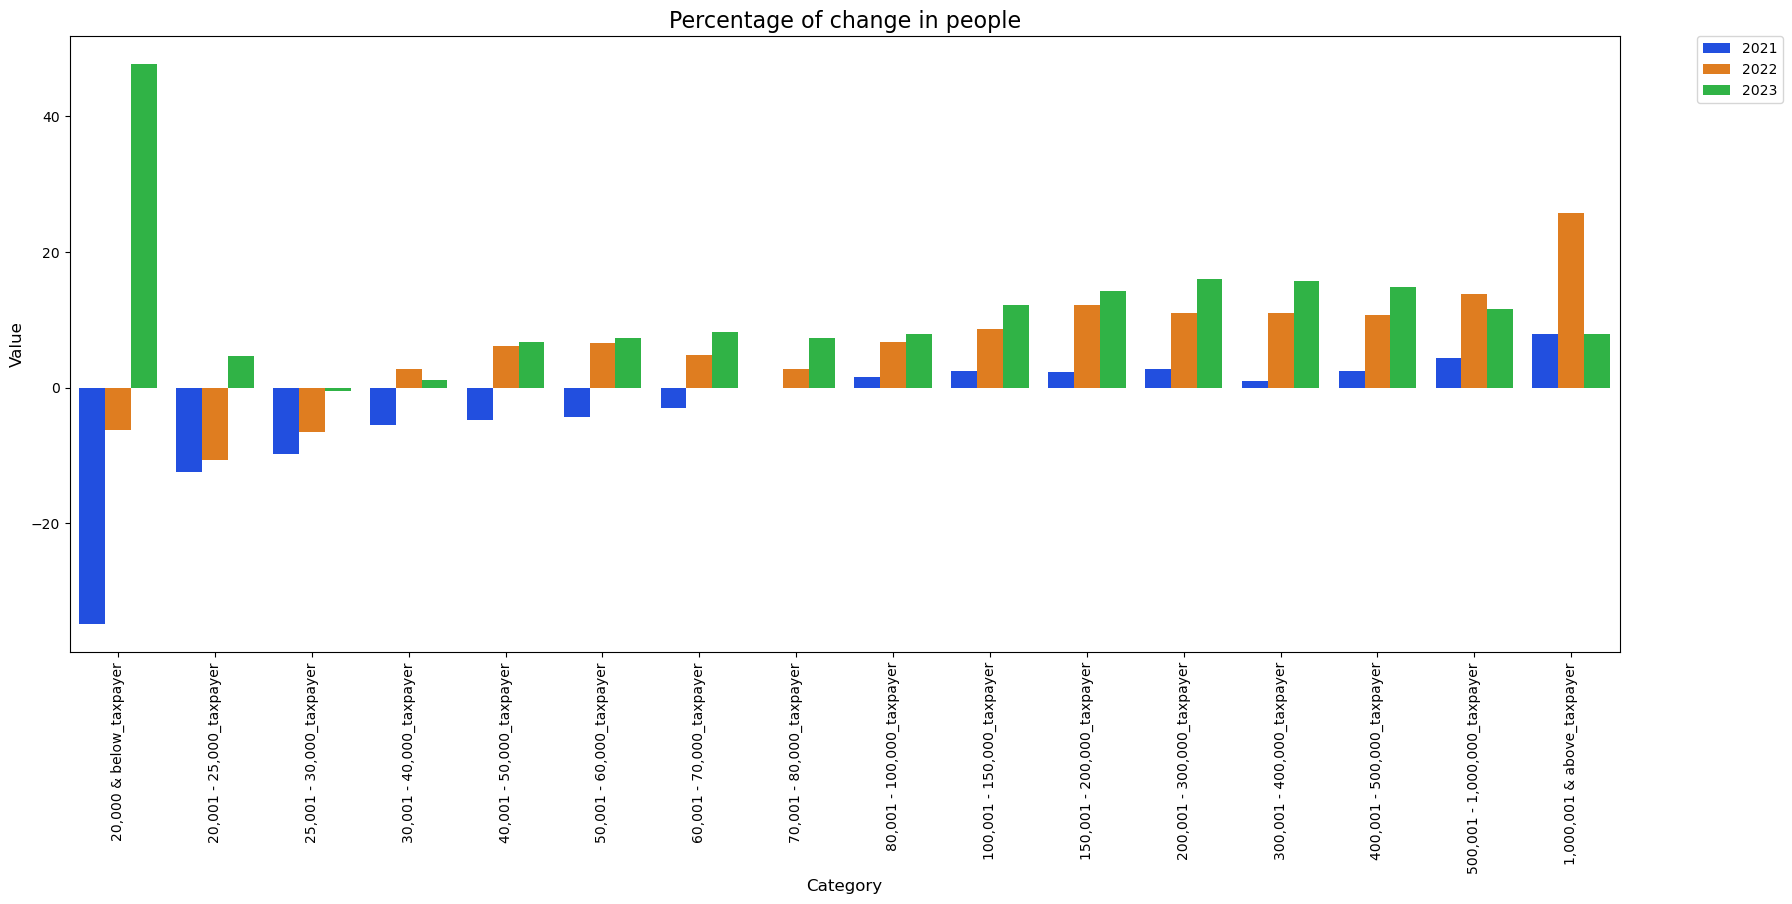

In [13]:
order = [
        '20,000 & below_taxpayer', '20,001 - 25,000_taxpayer', '25,001 - 30,000_taxpayer', '30,001 - 40,000_taxpayer', '40,001 - 50,000_taxpayer', 
        '50,001 - 60,000_taxpayer', '60,001 - 70,000_taxpayer', '70,001 - 80,000_taxpayer', '80,001 - 100,000_taxpayer',
        '100,001 - 150,000_taxpayer', '150,001 - 200,000_taxpayer','200,001 - 300,000_taxpayer', '300,001 - 400,000_taxpayer', '400,001 - 500,000_taxpayer', 
        '500,001 - 1,000,000_taxpayer', '1,000,001 & above_taxpayer']
plotting('Percentage of change in people', 'barplot', rate_change_income_ppl_df, 'category', 'ppl_increase_perc', 'year', order)

# total income

In [14]:
total_income_df = pd.DataFrame()
for year in [2020, 2021, 2022, 2023]:
    df = income_df[income_df['year_of_assessment'] == year].groupby('assessed_income_group')['assessable_income'].sum().reset_index()
    df = df.sort_values('assessed_income_group').T
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index(drop = True)
    df.columns = [col + '_income' for col in df.columns]
    df['total_income'] = df.sum(axis = 1)
    df['year'] = year
    total_income_df = pd.concat([total_income_df, df])

In [15]:
total_income_df

,"1,000,001 & above_income","100,001 - 150,000_income","150,001 - 200,000_income","20,000 & below_income","20,001 - 25,000_income","200,001 - 300,000_income","25,001 - 30,000_income","30,001 - 40,000_income","300,001 - 400,000_income","40,001 - 50,000_income","400,001 - 500,000_income","50,001 - 60,000_income","500,001 - 1,000,000_income","60,001 - 70,000_income","70,001 - 80,000_income","80,001 - 100,000_income",total_income,year
0,11909762,27827193,18095548,199866,1736114,21294598,3826622,12417910,12088738,11799785,7495001,10742424,13892256,9514880,8921925,15249244,187011866,2020
0,13622898,28473451,18503160,142867,1518132,21875081,3451771,11749914,12209168,11234762,7688262,10273332,14463621,9228980,8917741,15494988,188848128,2021
0,18839572,30937946,20764789,147542,1359162,24280136,3228202,12144477,13544317,11916574,8508599,10939881,16469380,9674373,9168427,16551474,208474851,2022
0,18930489,34713197,23737111,196299,1420805,28194932,3212930,12311502,15696823,12713998,9761092,11745611,18401363,10467655,9838043,17863868,229205718,2023


In [16]:
collapsed_total_income_df = pd.melt(total_income_df, id_vars=["year"], var_name="category", value_name="income_sum")

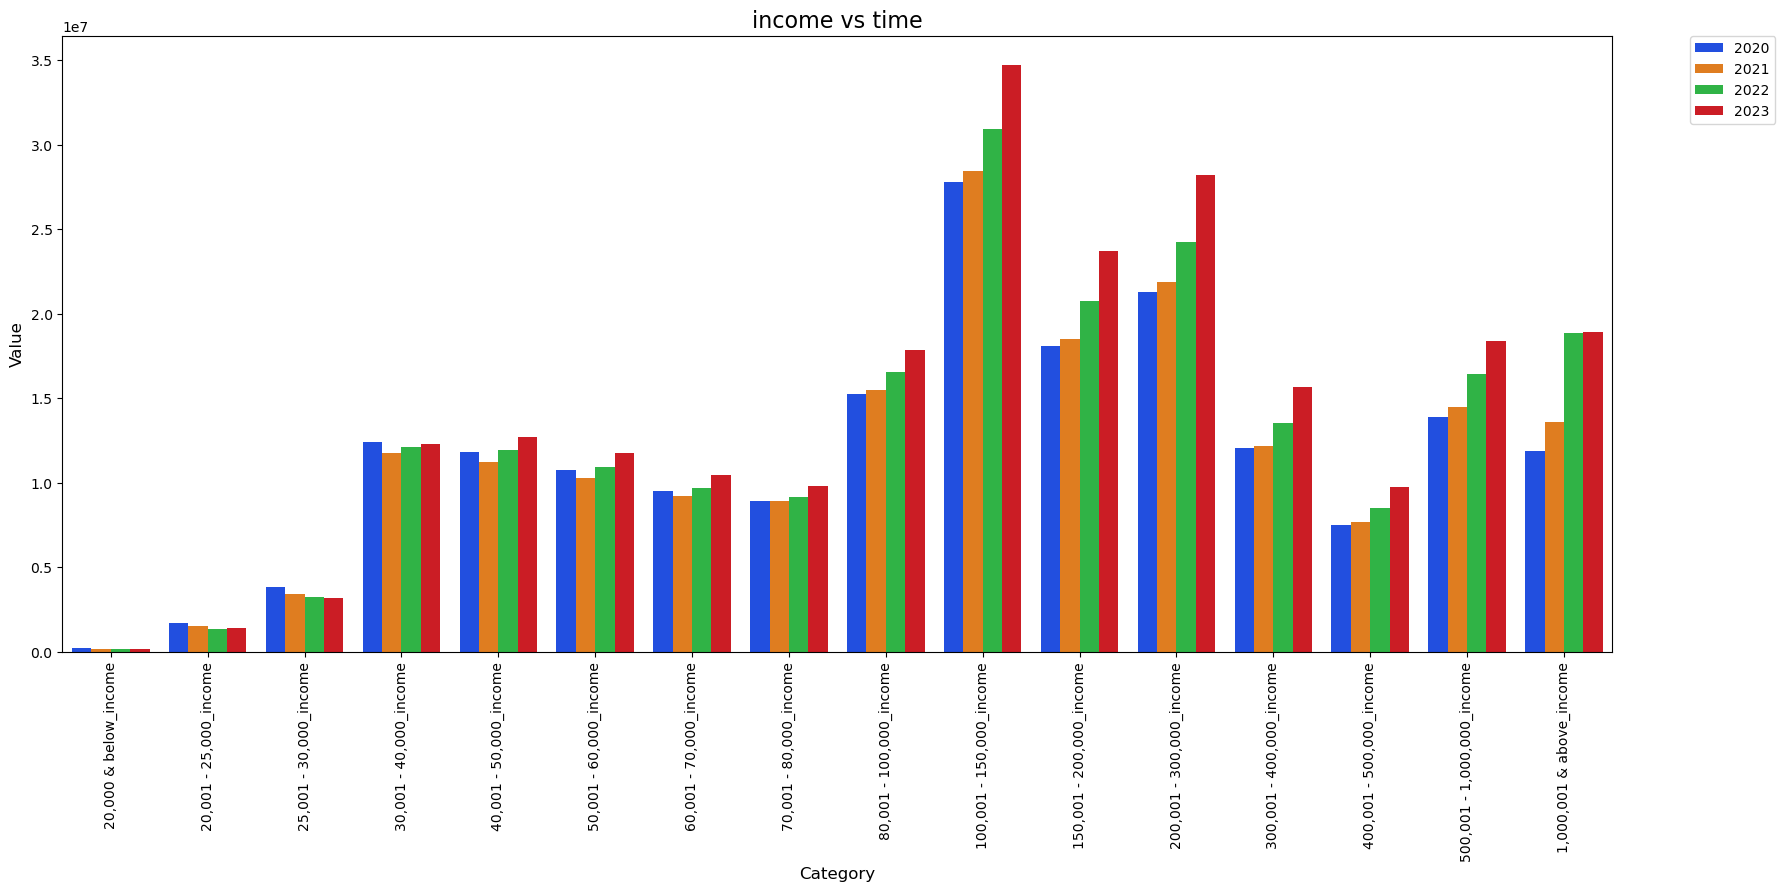

In [17]:
order = [
        '20,000 & below_income', '20,001 - 25,000_income', '25,001 - 30,000_income', '30,001 - 40,000_income', '40,001 - 50,000_income', 
        '50,001 - 60,000_income', '60,001 - 70,000_income', '70,001 - 80,000_income', '80,001 - 100,000_income',
        '100,001 - 150,000_income', '150,001 - 200,000_income','200,001 - 300,000_income', '300,001 - 400,000_income', '400,001 - 500,000_income', 
        '500,001 - 1,000,000_income', '1,000,001 & above_income']
df = collapsed_total_income_df[collapsed_total_income_df['category']!= 'total_income']
plotting('income vs time', 'barplot', df, 'category', 'income_sum', 'year', desired_order = order)

In [18]:
rental_data_df = rental_data_df.merge(total_income_df, on = 'year', how = 'left')
rental_data_df.head()

,rent_approval_date,town,block,street_name,flat_type,monthly_rent,address,date,year,month,year_month,postal_code,latitude,longitude,"1,000,001 & above_income","100,001 - 150,000_income","150,001 - 200,000_income","20,000 & below_income","20,001 - 25,000_income","200,001 - 300,000_income","25,001 - 30,000_income","30,001 - 40,000_income","300,001 - 400,000_income","40,001 - 50,000_income","400,001 - 500,000_income","50,001 - 60,000_income","500,001 - 1,000,000_income","60,001 - 70,000_income","70,001 - 80,000_income","80,001 - 100,000_income",total_income
0,2021-01,ANG MO KIO,105,ANG MO KIO AVE 4,4-ROOM,2000,105 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560105,1.372313,103.837601,13622898,28473451,18503160,142867,1518132,21875081,3451771,11749914,12209168,11234762,7688262,10273332,14463621,9228980,8917741,15494988,188848128
1,2021-01,ANG MO KIO,107,ANG MO KIO AVE 4,3-ROOM,1750,107 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560107,1.371384,103.837381,13622898,28473451,18503160,142867,1518132,21875081,3451771,11749914,12209168,11234762,7688262,10273332,14463621,9228980,8917741,15494988,188848128
2,2021-01,ANG MO KIO,108,ANG MO KIO AVE 4,3-ROOM,1750,108 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560108,1.370966,103.838202,13622898,28473451,18503160,142867,1518132,21875081,3451771,11749914,12209168,11234762,7688262,10273332,14463621,9228980,8917741,15494988,188848128
3,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2230,111 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560111,1.370851,103.837298,13622898,28473451,18503160,142867,1518132,21875081,3451771,11749914,12209168,11234762,7688262,10273332,14463621,9228980,8917741,15494988,188848128
4,2021-01,ANG MO KIO,111,ANG MO KIO AVE 4,5-ROOM,2450,111 ANG MO KIO AVE 4,2021-01-01,2021,1,2021_1,560111,1.370851,103.837298,13622898,28473451,18503160,142867,1518132,21875081,3451771,11749914,12209168,11234762,7688262,10273332,14463621,9228980,8917741,15494988,188848128
